### Rolling regression

In [1]:
import json
import matplotlib
import warnings

warnings.simplefilter('ignore')

root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

### Rolling Regression
[Pairs trading](https://www.quantopian.com/posts/pairs-trading-algorithm-1) is a famous techniques trading that plays two stocks against each other.
For this, stock must be correlated(cointegrated)
One common example is the price of gold(GLD) and the price of gold mining operations(GDX)

In [2]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from pandas_datareader import data
import numpy as np
import pymc3 as pm
import theano.tensor as T
import scipy
%matplotlib inline

In [3]:
## Load the Yahoo Data
prices = data.YahooDailyReader(symbols = ['GLD', 'GDX'], 
                               end = '2014-8-1').read().loc['Adj Close', :, :].iloc[:1000]
prices.head()

### here no need to center the predictor (remove the mean) the data seems to be on the same scale
### and most the time it's not necessary

,GDX,GLD
Date,,
2010-01-04,45.510644,109.800003
2010-01-05,45.949438,109.699997
2010-01-06,47.065505,111.510002
2010-01-07,46.836567,110.820000
2010-01-08,47.542455,111.370003


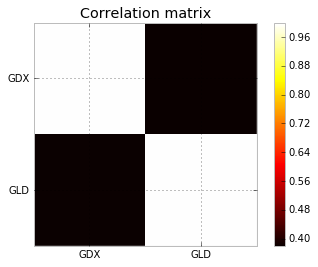

In [4]:
## correlation matrix betwenn GDX and GLD N x N (N : number of variable)
plt.imshow(np.corrcoef(prices['GDX'], prices['GLD']), interpolation = 'none', cmap = 'hot')
plt.xticks(np.arange(2), prices.columns)
plt.yticks(np.arange(2), prices.columns)
plt.colorbar(orientation = 'vertical')
plt.title("Correlation matrix");

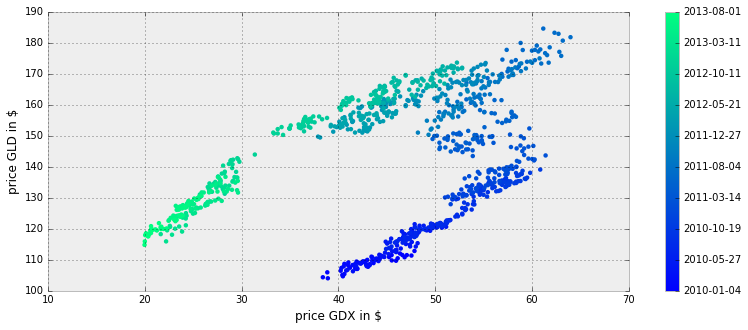

In [5]:
fig = plt.figure(figsize = (13, 5))
ax = fig.add_subplot(111, xlabel = "price GDX in \$", ylabel = "price GLD in \$")
colors = np.linspace(.1, 1, len(prices))
cmap = plt.get_cmap("winter")
sc = ax.scatter(prices.GDX, prices.GLD, cmap = cmap, c = colors, lw = 0)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices) // 10].index]);

In [6]:
def plot_trace(trace):
    
    """
    Convenience function:
    Plot the trace with the overlaid mean and variance
    """
    ax = pm.traceplot(trace, figsize(12.5, len(trace.varnames)*1.5),
                     lines = {k: v['mean'] for k, v in pm.df_summary(trace).iterrows()})
    
    for i, mean in enumerate(pm.df_summary(trace)['mean']):
        ax[i, 0].annotate('{:.2f}'.format(mean), xy =(mean, 0), xycoords = 'data', xytext = (5, 10),
                         textcoords = 'offset points', rotation = 90, va = 'bottom', fontsize = 'large',
                         color = '#AA0022')
        
        
def plot_posterior(prices, trace):
    """
    Convenience function:
    Plot the posterior predictive regression lines on the original dataset
    """
    
    fig = plt.figure(figsize = (12.5, 5))
    ax = fig.add_subplot(111, xlabel = "price GDX in \$", ylabel = "price GLD in \$",
                        title = "posterior predictive regression lines")
    colors = np.linspace(.1, 1, len(prices))
    cmap = plt.get_cmap('winter')
    sc = ax.scatter(prices.GDX, prices.GLD, c = colors, cmap = cmap, lw = 0)
    
    pm.glm.plot_posterior_predictive(trace, samples = 5000,  label = "Posterior predictive regression lines",
                                    lm = lambda x, sample : sample['Intercept'] + sample['GDX'] * x,
                                    eval = np.linspace(prices.GDX.min(), prices.GDX.max(), 5000))
    cb = plt.colorbar(sc)
    cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);
    ax.legend(loc = 0);
    

Optimization terminated successfully.
         Current function value: 4355.946075
         Iterations: 8
         Function evaluations: 317


100%|██████████| 20000/20000 [00:38<00:00, 523.11it/s]


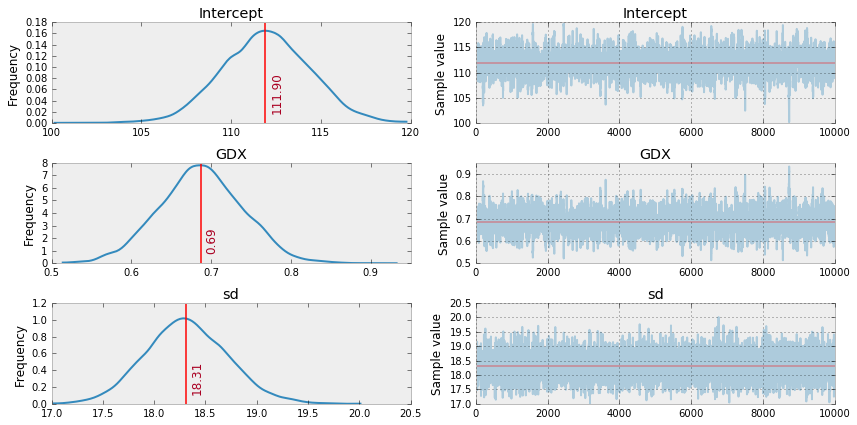

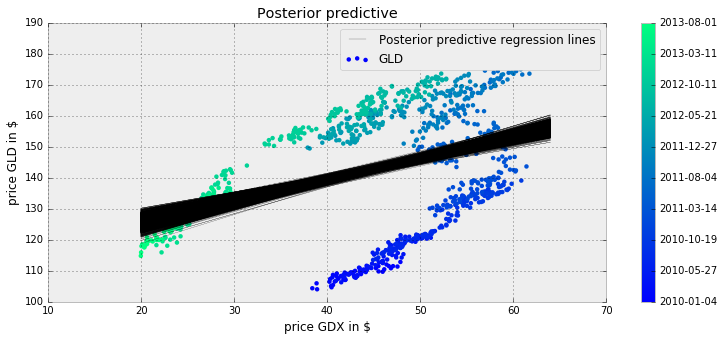

In [7]:
## First let's take a naive approach with a simple OLS, ignoring the time domain

with pm.Model() as model_LR:
    
    # Linear regression model
    pm.glm.glm('GLD ~ GDX', prices)
    
    # Optimization (fmin = scipy.optimize.fmin_l_bfgs_b when use : for a more complex prior space ?)
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS(scaling = start)
    
    #Compute the posterior
    trace_LR = pm.sample(20000, start = start, step = step)
    burned_LR = trace_LR[10000:]
    
plot_trace(burned_LR)
plot_posterior(prices, burned_LR)

Optimization terminated successfully.
         Current function value: 4355.946075
         Iterations: 8
         Function evaluations: 317


100%|██████████| 20000/20000 [00:38<00:00, 525.35it/s]


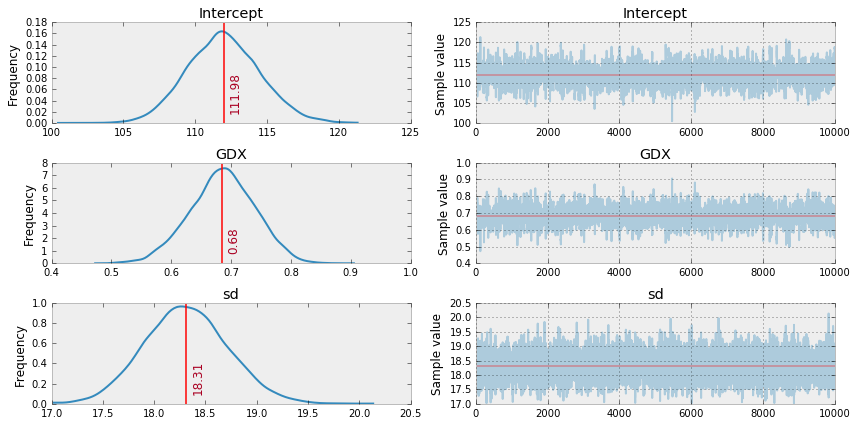

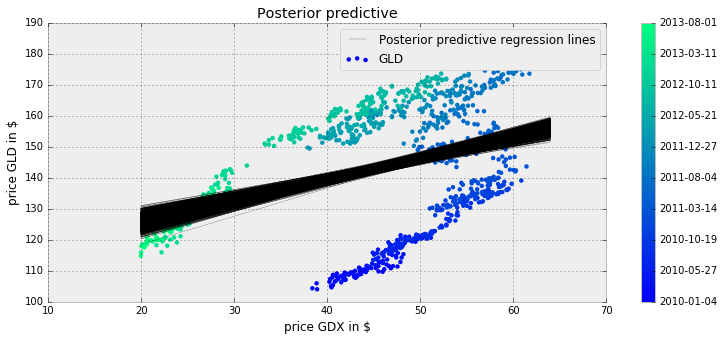

In [8]:
## TODO
## OLS, Ridge regression, StudentT Regression, rolling regression, compare the tree model

## Second let's do something a bit more sophisticated, but still ignoring the time domain : Normal OLS
with pm.Model() as model_OLS:
    
    # Ordinary Least Squares Model
    family = pm.glm.families.Normal()
    pm.glm.glm('GLD ~ 1 + GDX', prices, family = family)
    
    #optimization
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS(scaling = start)
    
    # Compute the posterior distribution
    trace = pm.sample(20000, start = start, step = step)
    burned_OLS = trace[10000:] 
    
plot_trace(burned_OLS)
plot_posterior(prices, burned_OLS)

In [9]:
### Both LR and OLS seems to be the exact same ! try to specify some prior to see what happens

Optimization terminated successfully.
         Current function value: 4617.734285
         Iterations: 8
         Function evaluations: 287


100%|██████████| 20000/20000 [00:41<00:00, 476.27it/s]


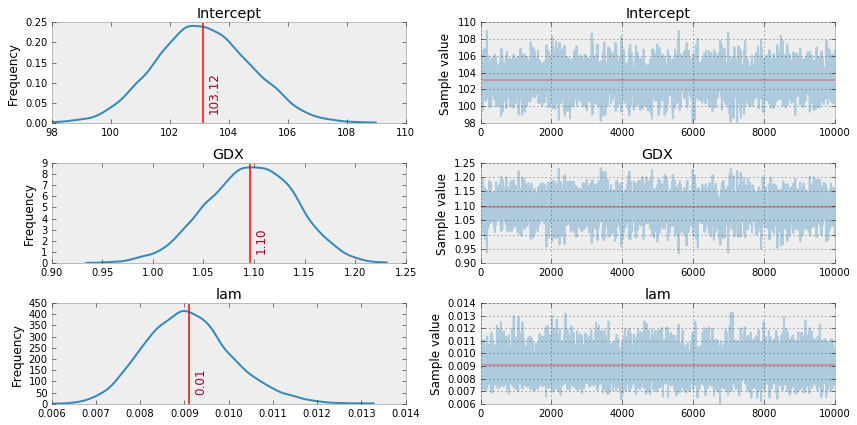

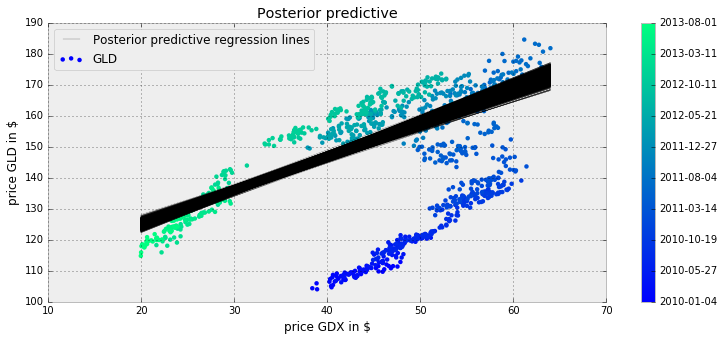

In [10]:
## StudenT Regression 
with pm.Model() as model_StudentT:
    
    #the model
    family = pm.glm.families.StudentT()
    pm.glm.glm('GLD ~ 1 + GDX', prices, family = family)
    
    # Optimization
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS(scaling = start)
    
    #sampling
    trace_StudentT = pm.sample(20000, step = step, start = start)
    burned_StudentT = trace_StudentT[10000:]
    
## Plots
plot_trace(burned_StudentT)
plot_posterior(prices, burned_StudentT)

### Let's Try a Rolling regression
Our goal now is to build an improved a model that will allow changes in the regression coefficients over time.
Specifically, we will assume that the intercept and the slope follow a random-walk through time.
The idea is similary to the stochastic volatility model seen before in training_1 : also found in the pymc3 <i>Examples</i> // <i>Apllied</i> : https://pymc-devs.github.io/pymc3/notebooks/stochastic_volatility.html

$$\begin{aligned}
  \alpha_t &\sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^{2}) \\
  \beta_t &\sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^{2}) \\
\end{aligned}$$

Let's define the hyper-priors $\sigma_{\alpha}^{2}$ and  $\sigma_\beta^{2}$ : this parameter can be interpreted as the volatility in the regression coefficients

In [11]:
##rolling regression

with pm.Model() as model_randomwalk:
    
    ##hyper parameters priors
    
    sigma_alpha = pm.Exponential("sigma_alpha", 1./.02, testval = .1)
    sigma_beta = pm.Exponential("sigma_beta", 1./.02, testval = .1)
    
    ## To make the model simpler we would apply the same coefficient do 50 data points at a time
    
    subsample_alpha = 50
    subsample_beta = 50
    
    alpha = pm.GaussianRandomWalk("alpha", sigma_alpha**-2, shape = len(prices)//subsample_alpha)
    beta = pm.GaussianRandomWalk("beta", sigma_beta**-2, shape = len(prices)//subsample_beta)
    
    ## Make the coefficients have the same lenght as prices
    
    alpha_r = T.repeat(alpha, subsample_alpha)
    beta_r = T.repeat(beta, subsample_beta)
    
    ##Define the regression model
    
    regression = alpha_r + beta_r * prices.GDX.values
    
    ## Likelihood and standard deviation 
    
    sd = pm.Uniform("sd", lower = 0, upper = 20)
    likelihood = pm.Normal("obs", mu = regression, sd = sd, observed = prices.GLD.values )
    
    ## Optimization
    
    start = pm.find_MAP(vars = [alpha, beta], fmin = scipy.optimize.fmin_l_bfgs_b)
    step = pm.NUTS(scaling = start)
    
    ##Sampling
    
    trace_GaussianRandomWalk = pm.sample(20000, start = start, step = step)
    burned_GaussianRandomWalk = trace_GaussianRandomWalk[10000:]

100%|██████████| 20000/20000 [05:50<00:00, 57.07it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123e24518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12462d828>]], dtype=object)

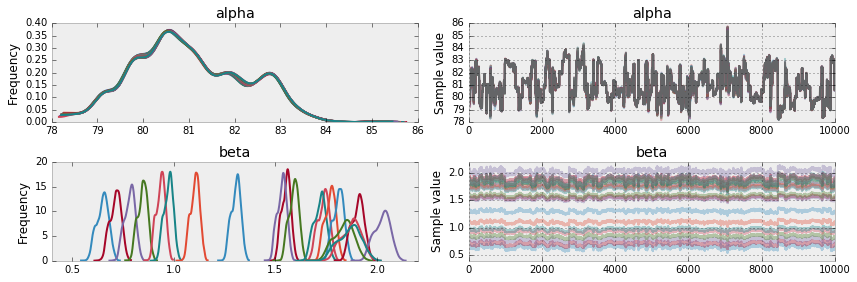

In [12]:
#pm.plots.plot_posterior(trace = burned_GaussianRandomWalk, varnames = ['alpha', 'beta'])
pm.plots.traceplot(trace = burned_GaussianRandomWalk, varnames = ['alpha', 'beta']);
#pm.plots.autocorrplot(trace = burned_GaussianRandomWalk, varnames = ['alpha', 'beta'])

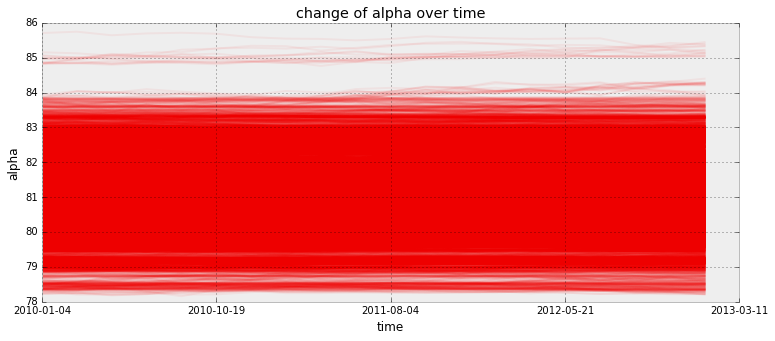

In [19]:
## Plot alpha across time

fig = plt.figure(figsize = (12.5, 5))
ax = plt.subplot(111, xlabel ="time", ylabel = "alpha", title = "change of alpha over time")
ax.plot(burned_GaussianRandomWalk['alpha'].T, 'r', alpha = .05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index])

##Comment:
#alpha,the intercept, does not seem to change over time

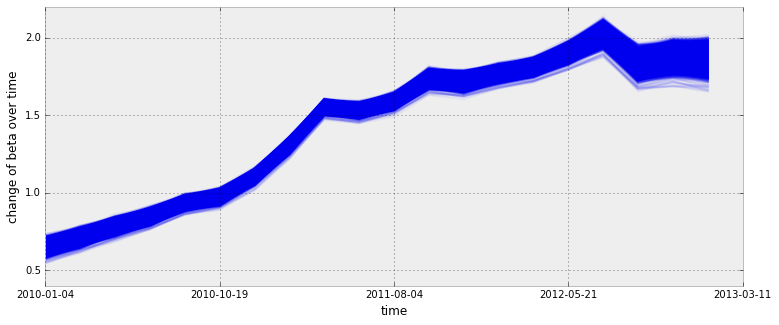

In [18]:
## Plot the slope over time

fig = plt.figure(figsize =(12.5, 5))
ax = plt.subplot(111, xlabel = "time", ylabel = "change of beta over time")
ax.plot(burned_GaussianRandomWalk['beta'].T, 'b', alpha = .05)
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

##Comment:
# However the slope does

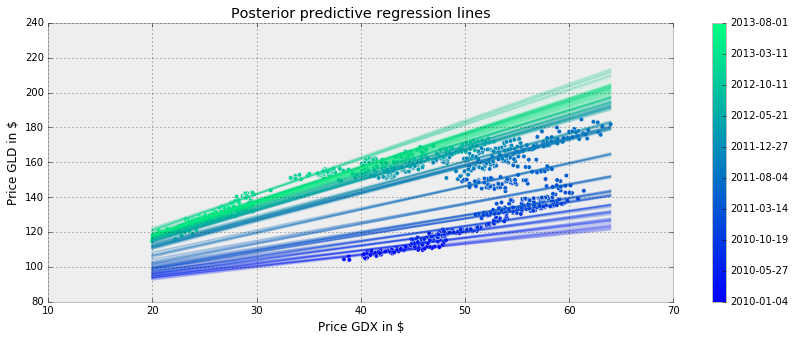

In [15]:
fig = plt.figure(figsize = (14, 5))
ax = fig.add_subplot(111, xlabel = "Price GDX in \$", ylabel = "Price GLD in \$",
                    title = "Posterior predictive regression lines")

colors = np.linspace(.1, 1,len(prices))
colors_sc = np.linspace(.1, 1,len(burned_GaussianRandomWalk[-500::10]['alpha'].T))
cmap = plt.get_cmap("winter")
_cmap = plt.get_cmap("winter")

xi = np.linspace(prices.GDX.min(), prices.GDX.max(), 50)
for i, (alpha, beta) in enumerate(zip(burned_GaussianRandomWalk[-500::10]['alpha'].T,
                                     burned_GaussianRandomWalk[-500::10]['beta'].T)):
    for a, b in zip(alpha, beta):
        ax.plot(xi, a + b * xi, alpha = .05, lw = 1,  c = _cmap(colors_sc[i]))
        
sc = ax.scatter(prices.GDX,prices.GLD, label = 'data', cmap = cmap, c = colors)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);


In [16]:
##It's clear that the rolling regression seems to be the best, but for the purpose  of learning,
##let's compute the DIC and the WAIC for the OLS, StudentT and GaussianRW models

import pandas as pd

df = pd.DataFrame(index = ['model_OLS', 'model_SudentT', 'model_randomwalk'], columns = ['DIC', 'WAIC'])
traces = [burned_OLS, burned_StudentT, burned_GaussianRandomWalk]
models = [model_OLS, model_StudentT, model_randomwalk]
model_dict = {k: v for k, v in zip(df.index, models)

for model_name, trace in zip(models, traces):
    df.loc[model_name, 'DIC'] = pm.stats.dic(trace = trace, model = model_name)
    df.loc[model_name, 'WAIC'] = pm.stats.waic(trace = trace, model = model_name)[0]
              
df

SyntaxError: invalid syntax (<ipython-input-16-eed3928a55e5>, line 11)